In [12]:
import pandas as pd
import urllib2
import json
import io
import os
import networkx as nx
import re
import matplotlib.pyplot as plt
import numpy as np
from fa2 import ForceAtlas2

%matplotlib inline

In [13]:
df = pd.read_csv('./character.csv')

In [14]:
df.head()

,Unnamed: 0,page_id,title,House
0,0,4982,Template:Gryffindor individual infobox,Gryffindors
1,1,33349,Astrix Alixan,Gryffindors
2,2,33353,Filemina Alchin,Gryffindors
3,3,7018,Euan Abercrombie,Gryffindors
4,4,99282,Sakura Akagi,Gryffindors


In [15]:
basequery = 'http://harrypotter.wikia.com/api.php?action=query&format=json&prop=revisions&rvprop=content'

def create_query(pageid):
    return basequery+'&pageids='+str(pageid)

In [16]:
response =  urllib2.urlopen(create_query(33349))
response_dict = json.loads(response.read())

In [17]:
def format_filename(name):
    return os.path.join('data/%s.json') % (name)

def dump_file(name, data):
    file_name = format_filename(name)
    with io.open(file_name, "w", encoding="utf-8") as f:
        f.write(unicode(json.dumps(data, ensure_ascii=False)))
    print("Wrote file: %s" % (file_name))

In [10]:
for pageid in df['page_id']:
    query = create_query(pageid)
    response =  urllib2.urlopen(query)
    response_dict = json.loads(response.read())
    for k in response_dict['query']['pages'].keys():
        dump_file(pageid, response_dict['query']['pages'][k]['revisions'][-1]['*'])

Wrote file: data/4982.json
Wrote file: data/33349.json
Wrote file: data/33353.json
Wrote file: data/7018.json
Wrote file: data/99282.json
Wrote file: data/99036.json
Wrote file: data/123475.json
Wrote file: data/59171.json
Wrote file: data/59173.json
Wrote file: data/59193.json
Wrote file: data/59177.json
Wrote file: data/28767.json
Wrote file: data/33354.json
Wrote file: data/98807.json
Wrote file: data/99269.json
Wrote file: data/33408.json
Wrote file: data/325.json
Wrote file: data/99052.json
Wrote file: data/8259.json
Wrote file: data/99277.json
Wrote file: data/197956.json
Wrote file: data/197957.json
Wrote file: data/36003.json
Wrote file: data/31.json
Wrote file: data/197958.json
Wrote file: data/37634.json
Wrote file: data/46445.json
Wrote file: data/137536.json
Wrote file: data/46451.json
Wrote file: data/99236.json
Wrote file: data/20.json
Wrote file: data/890.json
Wrote file: data/161113.json
Wrote file: data/98813.json
Wrote file: data/192662.json
Wrote file: data/197960.js

Wrote file: data/208585.json
Wrote file: data/205930.json
Wrote file: data/35207.json
Wrote file: data/7035.json
Wrote file: data/96953.json
Wrote file: data/96954.json
Wrote file: data/46384.json
Wrote file: data/90770.json
Wrote file: data/410.json
Wrote file: data/99637.json
Wrote file: data/100468.json
Wrote file: data/45810.json
Wrote file: data/185195.json
Wrote file: data/7034.json
Wrote file: data/947.json
Wrote file: data/34875.json
Wrote file: data/99618.json
Wrote file: data/99619.json
Wrote file: data/38278.json
Wrote file: data/6874.json
Wrote file: data/34737.json
Wrote file: data/4483.json
Wrote file: data/5092.json
Wrote file: data/7039.json
Wrote file: data/328.json
Wrote file: data/7030.json
Wrote file: data/100481.json
Wrote file: data/89466.json
Wrote file: data/34449.json
Wrote file: data/99620.json
Wrote file: data/2836.json
Wrote file: data/99621.json
Wrote file: data/99622.json
Wrote file: data/39000.json
Wrote file: data/119219.json
Wrote file: data/100482.json

Wrote file: data/83.json
Wrote file: data/2762.json
Wrote file: data/36334.json
Wrote file: data/865.json
Wrote file: data/36.json
Wrote file: data/6310.json
Wrote file: data/192663.json
Wrote file: data/82797.json
Wrote file: data/161921.json
Wrote file: data/161975.json
Wrote file: data/100502.json
Wrote file: data/35220.json
Wrote file: data/35967.json
Wrote file: data/679.json
Wrote file: data/14699.json
Wrote file: data/18212.json
Wrote file: data/18211.json
Wrote file: data/34879.json
Wrote file: data/34891.json
Wrote file: data/547.json
Wrote file: data/44396.json
Wrote file: data/34860.json
Wrote file: data/44389.json
Wrote file: data/198022.json
Wrote file: data/100531.json
Wrote file: data/126518.json
Wrote file: data/7055.json
Wrote file: data/34865.json
Wrote file: data/3389.json
Wrote file: data/42332.json
Wrote file: data/35115.json
Wrote file: data/96195.json
Wrote file: data/77774.json
Wrote file: data/77775.json
Wrote file: data/35154.json
Wrote file: data/118961.json


In [28]:
regex = "\[\[(.*?)\]\]"

character_name = np.array(df.title)

G = nx.DiGraph()
id_dict = {}
count = 1.0
for index, row in df.iterrows():
    #id_dict[row['title']] = count
    G.add_node(row['title'], house=row['House'], pageid=row['page_id'])
    count += 1.0

for index, row in df.iterrows():
    with io.open(format_filename(row['page_id']), 'r', encoding='utf-8') as f:
        content = json.load(f)
    links = re.findall(regex, content)
    
    for link in links:
        for l in link.split('|'): 
            if l in character_name:
                G.add_edge(row['title'], l)

In [37]:
nx.write_gexf(G, "graph.gexf")

In [27]:
positions

{1.0: (143.07766191793516, 38.25263675121122),
 2.0: (-91.00710018268866, 54.161953320286784),
 3.0: (-129.4675298123141, 13.144201743464924),
 4.0: (-23.20866953510795, 85.83470077003646),
 5.0: (114.22885544928519, -82.392200606137),
 6.0: (-58.13032521467844, 129.47479017034905),
 7.0: (111.35962781514715, -77.05257170451199),
 8.0: (93.58474135708404, 104.3628453144682),
 9.0: (43.83748224629667, 135.82884411333686),
 10.0: (37.35615574014892, 127.83854930020665),
 11.0: (-30.051369660262754, -146.39015309120862),
 12.0: (-137.18415980599332, -41.54669334338287),
 13.0: (-124.24871286162971, -86.62492243544175),
 14.0: (86.23600365158751, 94.86375079100546),
 15.0: (105.8639304497126, -84.96884875470523),
 16.0: (-103.63848267429023, -115.76687344661104),
 17.0: (-103.74464651379414, -23.253366429399975),
 18.0: (-34.490045668657785, -143.20981180599435),
 19.0: (-18.550936425443208, 12.891483699881237),
 20.0: (134.3129281747257, -61.35960803862518),
 21.0: (-84.07906476349267, -1

In [30]:
# Calculate positions using the force atlas algorithm
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=1.0,
                          strongGravityMode=False,
                          gravity=50.0,

                          # Log
                          verbose=False)

positions = forceatlas2.forceatlas2_networkx_layout(nx.Graph(G), pos=None, iterations=3000)

In [31]:
positions['Harry Potter']

(-60.433453910100184, -33.877179525589725)

In [36]:
nx.set_node_attributes(G, {k: v[0] for k, v in positions.iteritems()}, name="x")
nx.set_node_attributes(G, {k: v[1] for k, v in positions.iteritems()}, name="y")


node_degree = {n: G.degree(n)*0.8+1 for n in G.nodes}
node_colors = {k: house_color_dict[v['house']] for k, v in G.nodes.data()}

nx.set_node_attributes(G, node_degree, "size")
nx.set_node_attributes(G, node_colors, "color")


In [35]:
house_color_dict = {
    'Gryffindors': '#740001',
    'Hufflepuffs': '#ecb939',
    'Slytherins': '#3d6b58',
    'Ravenclaws': '#222f5b',
    'Unknown_House': 'gray'
}

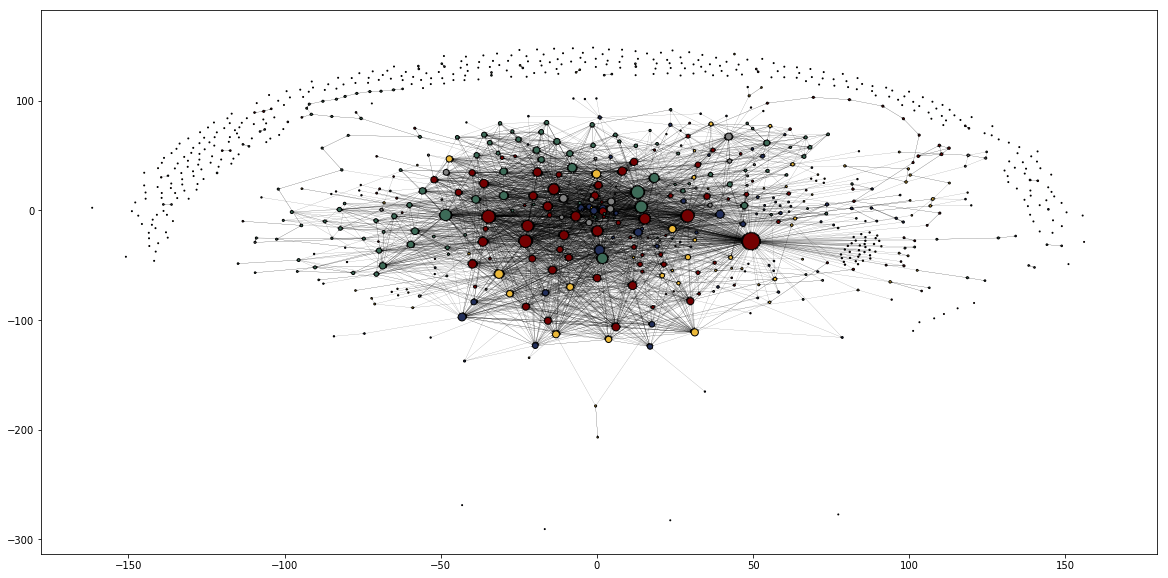

In [117]:
plt.figure(figsize=(20,10))
node_degree = [G.degree(n)*0.8+1 for n in G.nodes]
node_colors = [house_color_dict[v['house']] for k, v in G.nodes.data()]
nx.draw_networkx(G, positions, 
                 cmap=plt.get_cmap('jet'), 
                 node_size=node_degree, 
                 node_color=node_colors, 
                 arrows = True,
                 width = 0.1,
                 with_labels=False,
                 linewidths=1., 
                 arrowsize=2)
plt.gca().collections[0].set_edgecolor("#000000")

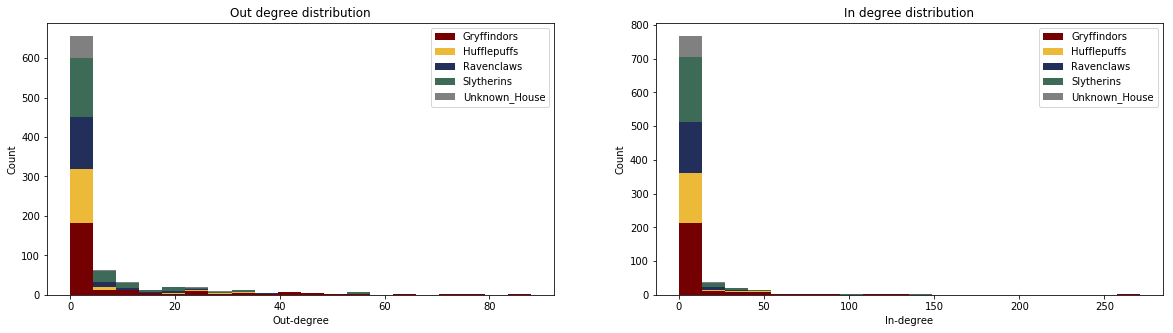

In [121]:
color_list = [v for h, v in house_color_dict.iteritems()]

in_degrees = [sorted([G.in_degree(k) for k, v in G.nodes.data() if v['house'] == h], reverse=True) \
              for h, _ in house_color_dict.iteritems()]
out_degrees = [sorted([G.out_degree(k) for k, v in G.nodes.data() if v['house'] == h], reverse=True) \
              for h, _ in house_color_dict.iteritems()]

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(out_degrees, bins = 20, stacked=True, color=color_list)
plt.title('Out degree distribution')
plt.xlabel('Out-degree')
plt.ylabel('Count')
plt.legend(house_color_dict)
plt.subplot(122)
plt.hist(in_degrees, bins = 20, stacked=True, color=color_list)
plt.title('In degree distribution')
plt.xlabel('In-degree')
plt.ylabel('Count')
plt.legend(house_color_dict)

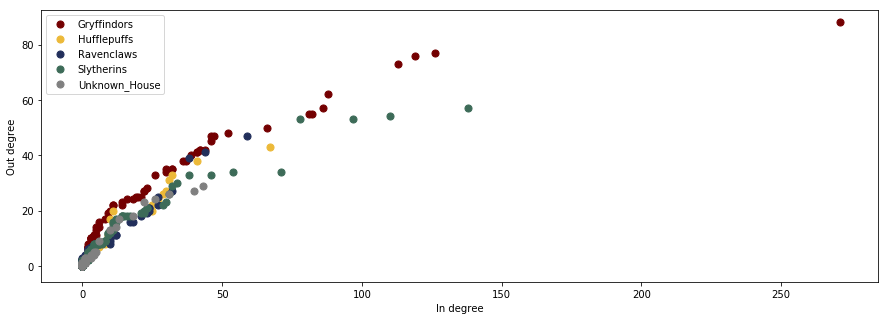

In [126]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
for i, c in enumerate(house_color_dict.itervalues()):
    scatter = ax.scatter(in_degrees[i], out_degrees[i], c=color_list[i],s=50)
plt.xlabel('In degree')
plt.ylabel('Out degree')
plt.legend(house_color_dict)

Text(0.5,1,'In degree - log scale')

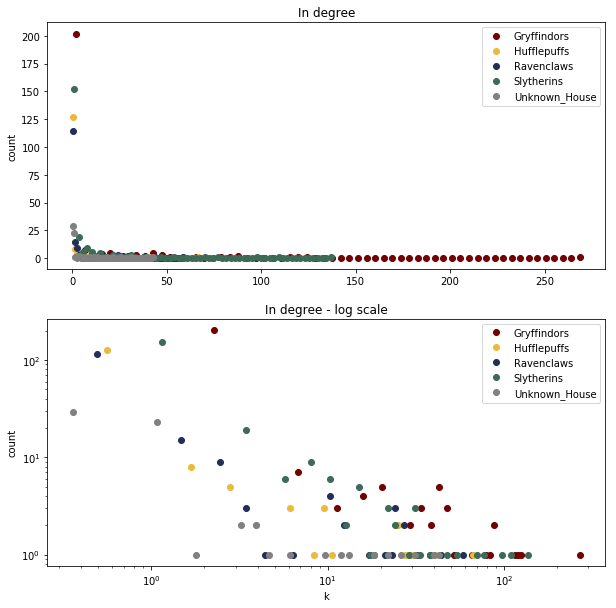

In [125]:
hists = [np.histogram(i, 60) for i in in_degrees]
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for i, h in enumerate(hists):
    plt.plot(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.ylabel("count")
plt.title('In degree')
plt.legend(house_color_dict)
plt.subplot(2,1,2)
plt.xlabel("k")
plt.ylabel("count")
for i, h in enumerate(hists):
    plt.loglog(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.legend(house_color_dict)
plt.title('In degree - log scale')

Text(0.5,1,'In degree - log scale')

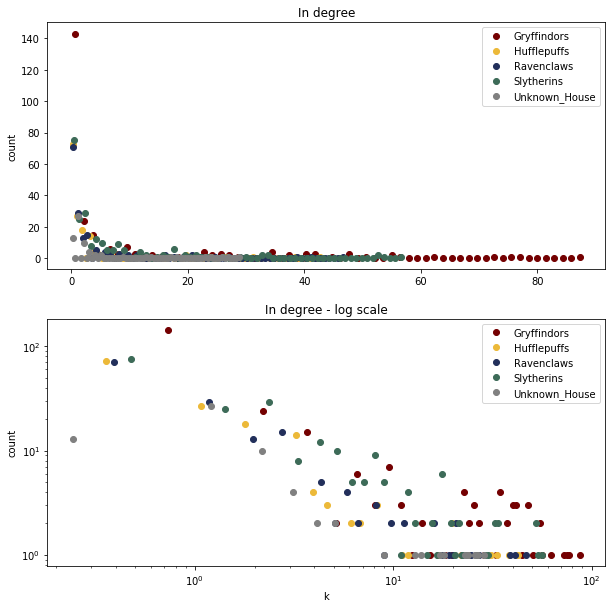

In [127]:
hists = [np.histogram(i, 60) for i in out_degrees]
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for i, h in enumerate(hists):
    plt.plot(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.ylabel("count")
plt.title('In degree')
plt.legend(house_color_dict)
plt.subplot(2,1,2)
plt.xlabel("k")
plt.ylabel("count")
for i, h in enumerate(hists):
    plt.loglog(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.legend(house_color_dict)
plt.title('In degree - log scale')